In [1]:
from collections import defaultdict

import networkx as nx
from scipy.sparse import linalg as scp_sla
import numpy as np
import matplotlib.pyplot as plt

import sim_lib.util as util
import sim_lib.graph_networkx as gnx
import sim_lib.attr_lib.util as alu
from sim_lib.attr_lib.formation import *
import sim_lib.attr_lib.vis as vis

In [2]:
_N = 25

# Simul + some vis parameters
num_iters = 10
add_to_iter = 0
show_last = 0
show_every = 1
log_last = 0
log_every = 1

similarity_homophily, similarity_heterophily = alu.gen_similarity_funcs()
schelling_homophily, schelling_heterophily = alu.gen_schelling_seg_funcs(0.75)

params = {
    'context_count' : 2, # Needed for simple utility
    'k' : 1, # Needed for simple attribute utility
    'edge_selection' : alu.seq_projection_edge_edit,
    'attr_copy' : alu.freq_attr_copy,
    'seed_type' : 'grid', # Type of seed network
    'max_clique_size' : 10,
    'vtx_types' :
        {
            'wide' : { 'likelihood' : 0.5,
                      'struct_util' : alu.ball2_size,
                      'init_attrs' : alu.init_cont_heterophily,
                      'edge_attr_util' : similarity_heterophily,
                      'total_attr_util' : schelling_heterophily,
                      'color' : 'blue' },
            'tall' : { 'likelihood' : 0.5,
                      'struct_util' : alu.potential_density,
                      'init_attrs' : alu.init_cont_homophily,
                      'edge_attr_util' : similarity_homophily,
                      'total_attr_util' : schelling_homophily,
                      'color' : 'red' }
        }
}

assert sum([ t['likelihood'] for t in params['vtx_types'].values() ]) == 1.0

In [3]:
def graph_density(G_nxc):
    denum = (len(G_nxc.nodes) * (len(G_nxc.nodes) - 1))
    num = sum([ G_nxc.degree[v] for v in G_nxc.nodes])
    if denum == 0:
        return -1
    return num / denum

def second_eigv(G_nx):
    try:
        laplacian = nx.linalg.laplacianmatrix.normalized_laplacian_matrix(G_nx)
        eigvals = scp_sla.eigs(laplacian.toarray(), return_eigenvectors=False)
        eigvals.sort()
        return eigvals[1]
    except:
        return -1

def apl(G_nx):
    return nx.average_shortest_path_length(G_nx)

def diam(G_nx):
    return nx.diameter(G_nx)

def bipartite_check(G_nx):
    return nx.is_bipartite(G_nx)

def modularity(G_nx):
    partitions = nx_comm.greedy_modularity_communities(G_nx)
    return nx_comm.modularity(G_nx, partitions)

def total_struct_util(G):
    return sum([ u.data['struct_util'](u, G) for u in G.vertices ])

def total_attribute_util(G):
    return sum([ u.data['total_attr_util'](u, G) for u in G.vertices ])

def average_neighborhood_overlap(G_nxc):
    nbor_overlaps = []
    vertices = list(G_nxc.nodes)
    for u_idx, u in enumerate(vertices):
        for v in vertices[u_idx + 1:]:
            nbor_overlaps.append(len(list(nx.common_neighbors(G_nxc, u, v))))
    return sum(nbor_overlaps) / len(vertices)

def print_metrics(G):
    G_nx = gnx.graph_to_nx(G)
    G_nx_comp_nodes = list(nx.connected_components(G_nx))
    G_nx_largest = G_nx.subgraph(max(G_nx_comp_nodes, key=len))
    G_nx_comps = [ G_nx.subgraph(G_nxc_nodes) for G_nxc_nodes in G_nx_comp_nodes ]
    
    component_sizes = [ len(G_nxc) for G_nxc in G_nx_comps ]
    gd = [ graph_density(G_nxc) for G_nxc in G_nx_comps ]
    avg_pl = apl(G_nx_largest)
    diameter = diam(G_nx_largest)
    eig2 = second_eigv(G_nx_largest)
    tsu = total_struct_util(G)
    tau = total_attribute_util(G)
    is_bp = bipartite_check(G_nx)
    anl = [ average_neighborhood_overlap(G_nxc) for G_nxc in G_nx_comps ]
    
    print(f"""Largest component size: {component_sizes}
graph density: {gd}, \n
average path length: {avg_pl}, \n
diameter: {diameter}, \n
second eigenvalue: {eig2} \n
total structural util: {tsu} \n
total attribute util: {tau} \n
is bipartite: {is_bp} \n
avg nbor overlap: {anl}\n""")

In [4]:
def plot_distributions(G):
    
    # Degree distribution
    degree_dist = [ v.degree for v in G.vertices ]
    norm_degree_dist = []
    if max(degree_dist) == 0:
        norm_degree_dist = [ 0 for d in degree_dist ]
    else:
        norm_degree_dist = [ d / max(degree_dist) for d in degree_dist ]
    
    G_nx = gnx.graph_to_nx(G)
    eigv_centralities = nx.eigenvector_centrality(G_nx, weight='util')
    eigv_centralities = list(eigv_centralities.values())
    
    metric_dists = [norm_degree_dist, eigv_centralities]
    dist_labels = ['norm degree', 'eigenvector cent']
    
    bins = np.linspace(0, 1, 100)
    plt.hist(metric_dists, bins, alpha=0.5, label=dist_labels)
    plt.legend(loc='upper right')
    plt.show()
    

{'context_count': 2, 'k': 1, 'edge_selection': <function seq_projection_edge_edit at 0x7f26751dd400>, 'attr_copy': <function freq_attr_copy at 0x7f26751dd6a8>, 'seed_type': 'grid', 'max_clique_size': 10, 'vtx_types': {'wide': {'likelihood': 0.5, 'struct_util': <function ball2_size at 0x7f267549ff28>, 'init_attrs': <function init_cont_heterophily at 0x7f267549f7b8>, 'edge_attr_util': <function gen_similarity_funcs.<locals>.heterophily at 0x7f26751ea2f0>, 'total_attr_util': <function gen_schelling_seg_funcs.<locals>.schelling_heterophily at 0x7f26751ea510>, 'color': 'blue'}, 'tall': {'likelihood': 0.5, 'struct_util': <function potential_density at 0x7f267549fe18>, 'init_attrs': <function init_cont_homophily at 0x7f267549f730>, 'edge_attr_util': <function gen_similarity_funcs.<locals>.homophily at 0x7f26751ea1e0>, 'total_attr_util': <function gen_schelling_seg_funcs.<locals>.schelling_homophily at 0x7f26751ea400>, 'color': 'red'}}, 'direct_cost': 0.08333333333333331, 'indirect_cost': 0.00

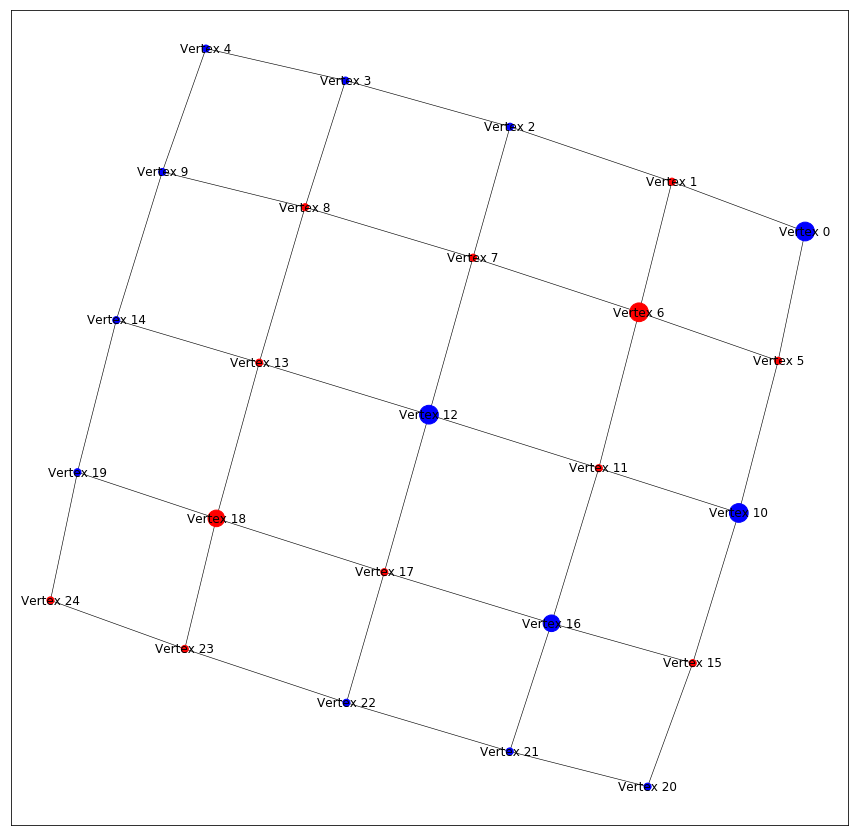

-----------------------------------------
Vertex 0 degree 2 budget 0.16666666666666663
[(-1.0, 0.08000000000000002, -0.09027777777777773), (0.0, 0.08000000000000002, -0.09722222222222221), (-1.0, 0.08000000000000002, -0.09027777777777773)]
[-0.010277777777777719, -0.017222222222222194, -0.010277777777777719]
[Vertex 2, Vertex 6, Vertex 10]
chose 1 (0.0, 0.08000000000000002, -0.09722222222222221) 0.0
chosen vtx Vertex 6
chose do nothing
###########################
Vertex 1 degree 3 budget 0.24999999999999994
[(0.0, 0.022222222222222223, -0.09027777777777773), (0.0, 0.044444444444444446, -0.09722222222222221), (0.0, 0.044444444444444446, -0.09722222222222221), (0.0, 0.022222222222222223, -0.09027777777777773)]
[-0.06805555555555551, -0.052777777777777764, -0.052777777777777764, -0.06805555555555551]
[Vertex 3, Vertex 5, Vertex 7, Vertex 11]
chose 0 (0.0, 0.022222222222222223, -0.09027777777777773) 0.0
chosen vtx Vertex 3
chose do nothing
###########################
Vertex 2 degree 3 budg

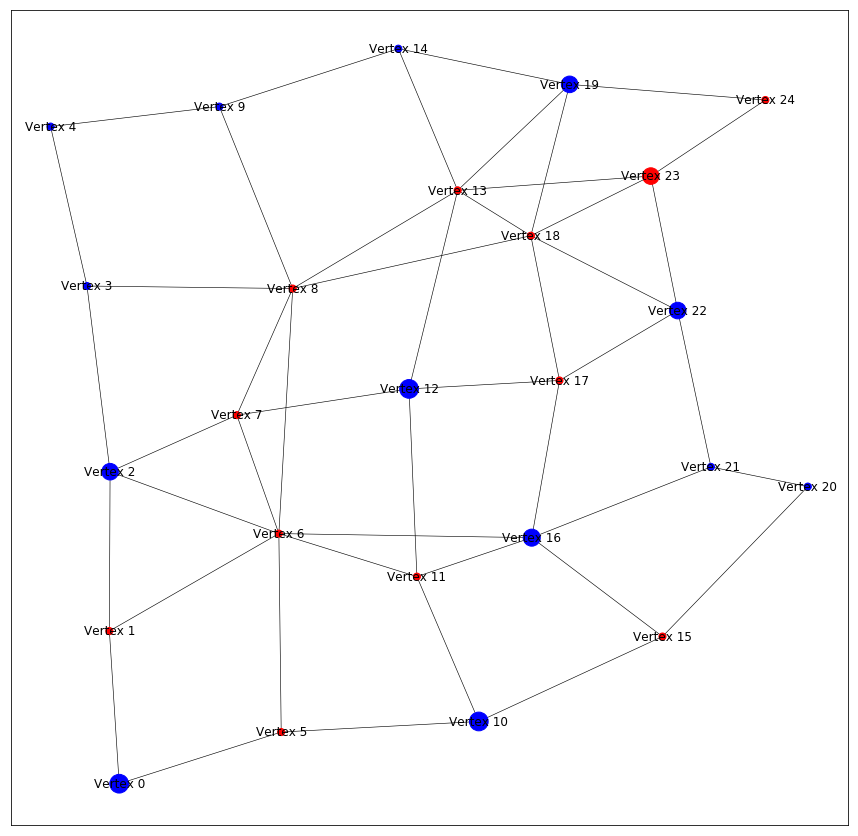

-----------------------------------------
Vertex 0 degree 2 budget 0.16666666666666663
[(-1.0, 0.08000000000000002, -0.09027777777777773), (0.0, 0.16000000000000003, -0.09722222222222221), (-1.0, 0.08000000000000002, -0.09027777777777773)]
[-0.010277777777777719, 0.06277777777777782, -0.010277777777777719]
[Vertex 2, Vertex 6, Vertex 10]
chose 1 (0.0, 0.16000000000000003, -0.09722222222222221) 0.0
chosen vtx Vertex 6
chose do nothing
###########################
Vertex 1 degree 3 budget 0.25694444444444436
[(0.0, 0.022222222222222223, -0.09027777777777779), (0.0, 0.04444444444444444, -0.09722222222222221), (0.0, 0.04444444444444444, -0.09722222222222221), (0.0, 0.022222222222222223, -0.09027777777777779), (0.0, 0.022222222222222223, -0.09027777777777779), (0.0, 0.022222222222222223, -0.09027777777777779)]
[-0.06805555555555556, -0.05277777777777777, -0.05277777777777777, -0.06805555555555556, -0.06805555555555556, -0.06805555555555556]
[Vertex 3, Vertex 5, Vertex 7, Vertex 8, Vertex 11,

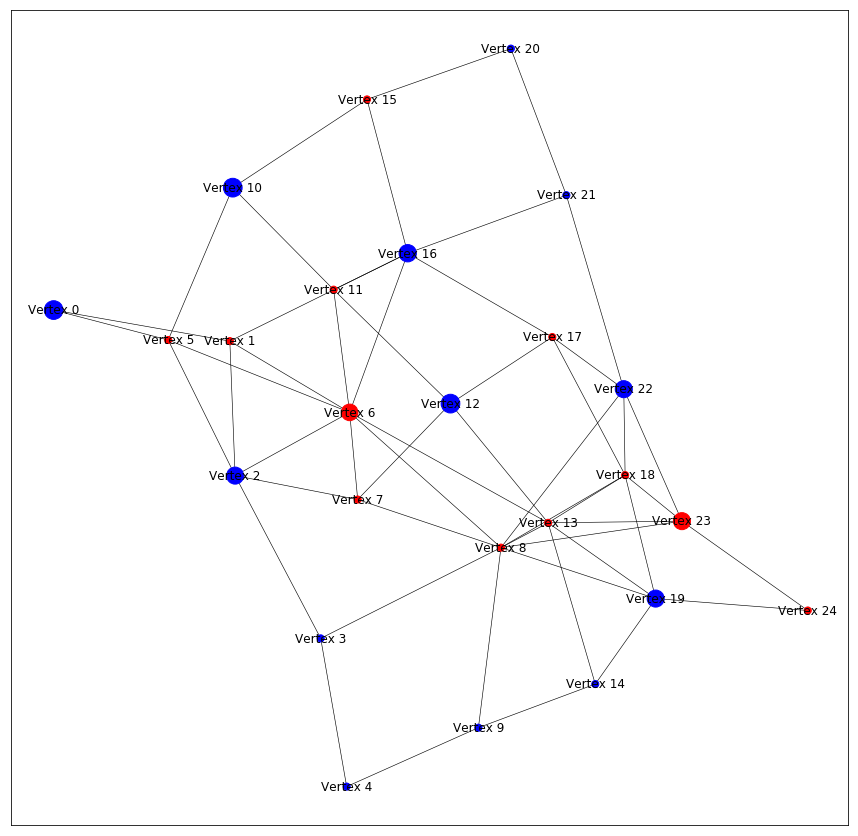

-----------------------------------------
Vertex 0 degree 2 budget 0.16666666666666663
[(-1.0, 0.07999999999999996, -0.09722222222222221), (0.0, 0.15999999999999998, -0.09722222222222221), (-1.0, 0.07999999999999996, -0.09027777777777773), (-1.0, 0.15999999999999998, -0.09027777777777773)]
[-0.01722222222222225, 0.06277777777777777, -0.010277777777777775, 0.06972222222222224]
[Vertex 2, Vertex 6, Vertex 10, Vertex 16]
chose 1 (0.0, 0.15999999999999998, -0.09722222222222221) 0.0
chosen vtx Vertex 6
chose do nothing
###########################
Vertex 1 degree 4 budget 0.34722222222222215
[(0.0, 0.02222222222222222, -0.09027777777777773), (0.0, 0.06666666666666665, -0.10416666666666663), (0.0, 0.044444444444444446, -0.09722222222222221), (0.0, 0.02222222222222222, -0.09027777777777773), (0.0, 0.044444444444444446, -0.09722222222222221), (0.0, 0.02222222222222222, -0.09027777777777773), (0.0, 0.02222222222222222, -0.09027777777777773), (0.0, 0.02222222222222222, -0.09027777777777773), (0.0

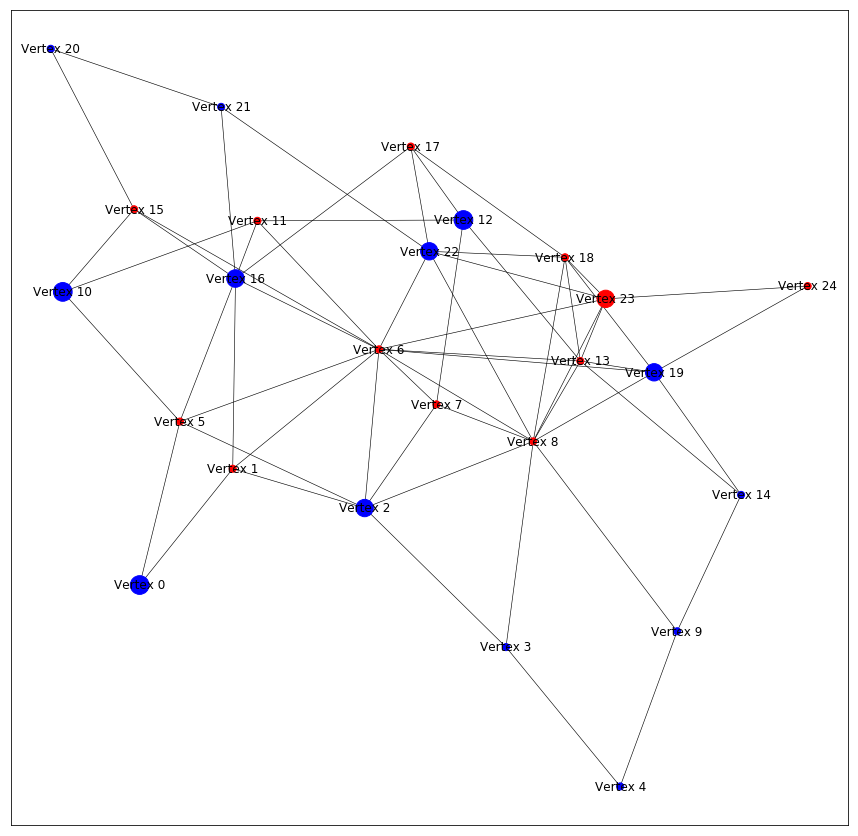

-----------------------------------------
Vertex 0 degree 2 budget 0.16666666666666663
[(-1.0, 0.12, -0.09722222222222221), (-1.0, 0.07999999999999996, -0.09027777777777773), (-1.0, 0.15999999999999998, -0.09722222222222221)]
[0.022777777777777786, -0.010277777777777775, 0.06277777777777777]
[Vertex 2, Vertex 10, Vertex 16]
chose 0 (-1.0, 0.12, -0.09722222222222221) -1.0
chosen vtx Vertex 2
chose do nothing
###########################
Vertex 1 degree 4 budget 0.34722222222222215
[(0.0, 0.02222222222222222, -0.09027777777777773), (0.0, 0.08888888888888888, -0.11111111111111105), (0.0, 0.044444444444444446, -0.09722222222222221), (0.0, 0.044444444444444446, -0.09722222222222221), (0.0, 0.044444444444444446, -0.09722222222222221), (0.0, 0.02222222222222222, -0.09027777777777773), (0.0, 0.044444444444444446, -0.09722222222222221), (0.0, 0.02222222222222222, -0.09027777777777773), (0.0, 0.02222222222222222, -0.09027777777777773), (0.0, 0.02222222222222222, -0.09027777777777773), (0.0, 0.022

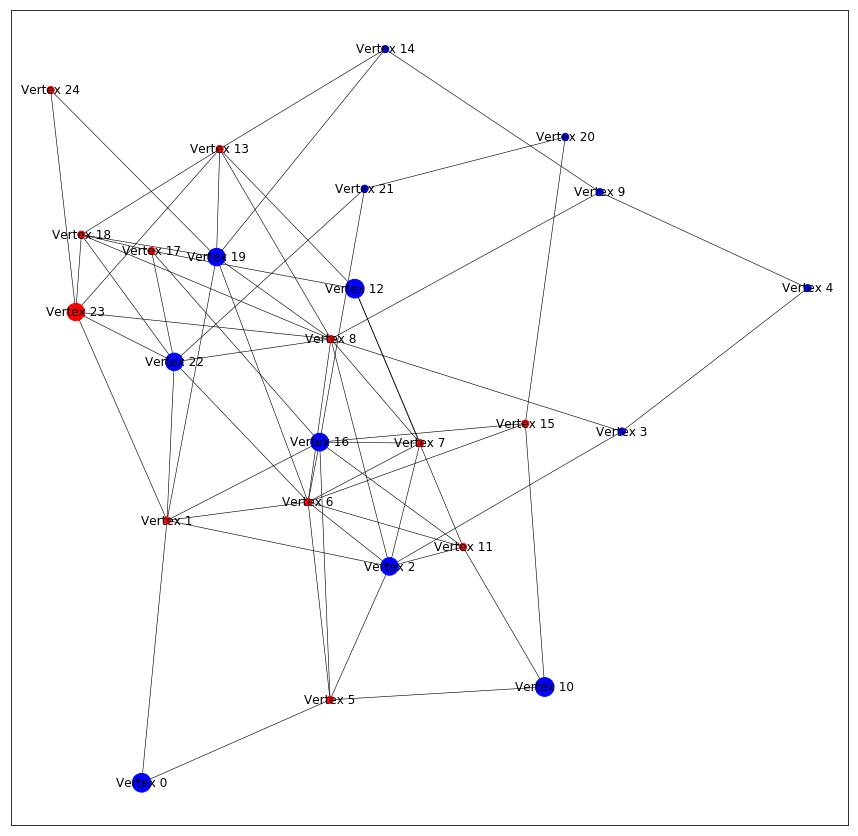

-----------------------------------------
Vertex 0 degree 2 budget 0.16666666666666663
[(-1.0, 0.16000000000000003, -0.09722222222222221), (0.0, 0.16000000000000003, -0.09722222222222221), (-1.0, 0.07999999999999996, -0.09027777777777773), (-1.0, 0.19999999999999996, -0.09722222222222221), (-1.0, 0.19999999999999996, -0.09027777777777773), (-1.0, 0.16000000000000003, -0.09027777777777773), (0.0, 0.16000000000000003, -0.09027777777777773)]
[0.06277777777777782, 0.06277777777777782, -0.010277777777777775, 0.10277777777777775, 0.10972222222222222, 0.0697222222222223, 0.0697222222222223]
[Vertex 2, Vertex 6, Vertex 10, Vertex 16, Vertex 19, Vertex 22, Vertex 23]
chose 1 (0.0, 0.16000000000000003, -0.09722222222222221) 0.0
chosen vtx Vertex 6
chose do nothing
###########################
Vertex 1 degree 7 budget 0.6180555555555555
[(0.0, 0.022222222222222227, -0.09027777777777768), (0.0, 0.0888888888888889, -0.11111111111111105), (0.0, 0.06666666666666668, -0.10416666666666663), (0.0, 0.1111

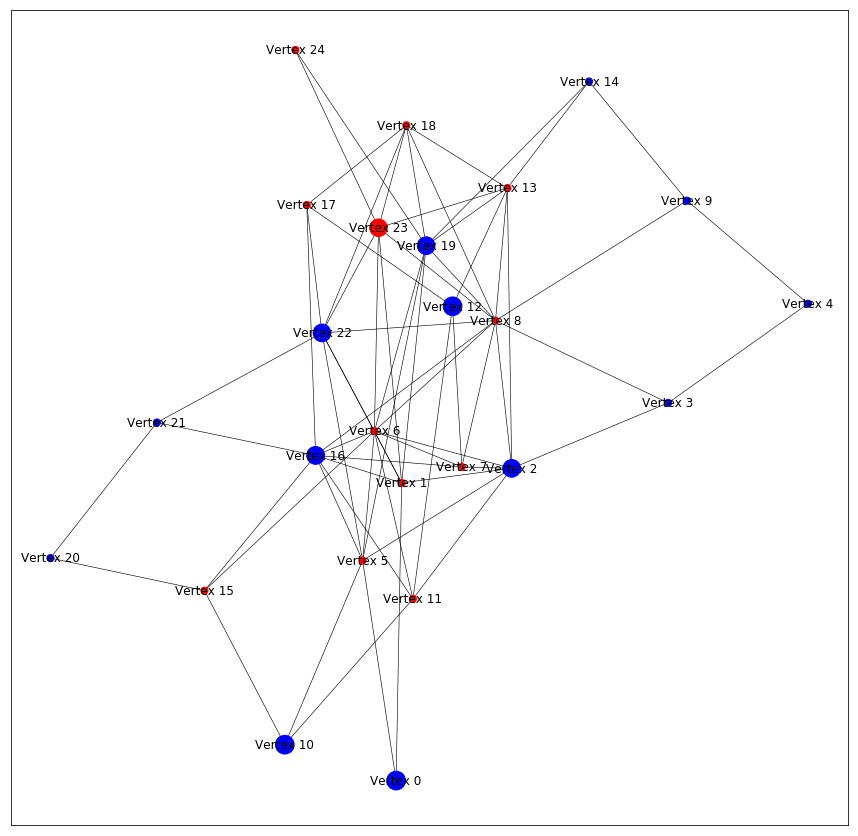

-----------------------------------------
Vertex 0 degree 2 budget 0.16666666666666663
[(-1.0, 0.19999999999999996, -0.09722222222222221), (-1.0, 0.07999999999999996, -0.09027777777777773), (-1.0, 0.24, -0.09722222222222221), (-1.0, 0.19999999999999996, -0.09722222222222221), (-1.0, 0.16000000000000003, -0.09722222222222221), (0.0, 0.16000000000000003, -0.09027777777777773)]
[0.10277777777777775, -0.010277777777777775, 0.14277777777777778, 0.10277777777777775, 0.06277777777777782, 0.0697222222222223]
[Vertex 2, Vertex 10, Vertex 16, Vertex 19, Vertex 22, Vertex 23]
chose 5 (0.0, 0.16000000000000003, -0.09027777777777773) 0.0
chosen vtx Vertex 23
chose do nothing
###########################
Vertex 1 degree 7 budget 0.6249999999999999
[(0.0, 0.022222222222222227, -0.09027777777777768), (0.0, 0.13333333333333333, -0.12499999999999989), (0.0, 0.06666666666666668, -0.10416666666666663), (0.0, 0.06666666666666668, -0.10416666666666663), (0.0, 0.06666666666666668, -0.10416666666666663), (0.0,

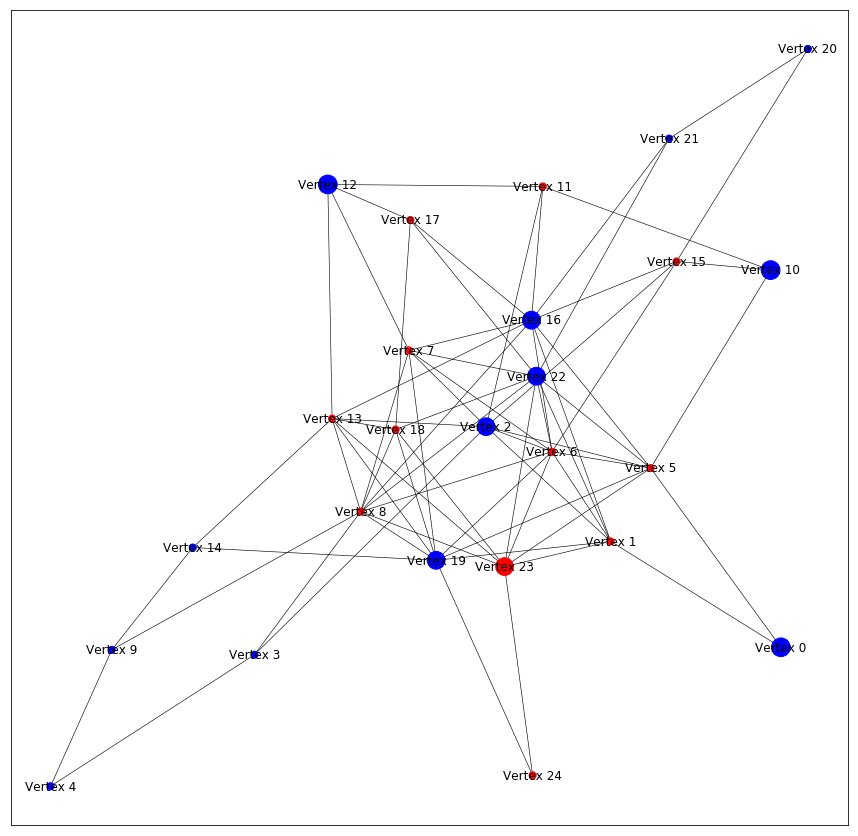

-----------------------------------------
Vertex 0 degree 2 budget 0.16666666666666663
[(-1.0, 0.19999999999999996, -0.09722222222222221), (0.0, 0.12, -0.09722222222222221), (-1.0, 0.07999999999999996, -0.09027777777777773), (-1.0, 0.28, -0.09722222222222221), (-1.0, 0.24, -0.09722222222222221), (-1.0, 0.19999999999999996, -0.09722222222222221), (0.0, 0.16000000000000003, -0.09722222222222221)]
[0.10277777777777775, 0.022777777777777786, -0.010277777777777775, 0.18277777777777782, 0.14277777777777778, 0.10277777777777775, 0.06277777777777782]
[Vertex 2, Vertex 6, Vertex 10, Vertex 16, Vertex 19, Vertex 22, Vertex 23]
chose 1 (0.0, 0.12, -0.09722222222222221) 0.0
chosen vtx Vertex 6
chose do nothing
###########################
Vertex 1 degree 7 budget 0.6249999999999999
[(0.0, 0.022222222222222227, -0.09027777777777768), (0.0, 0.15555555555555553, -0.1319444444444443), (0.0, 0.1111111111111111, -0.11805555555555547), (0.0, 0.1111111111111111, -0.11805555555555547), (0.0, 0.0444444444444

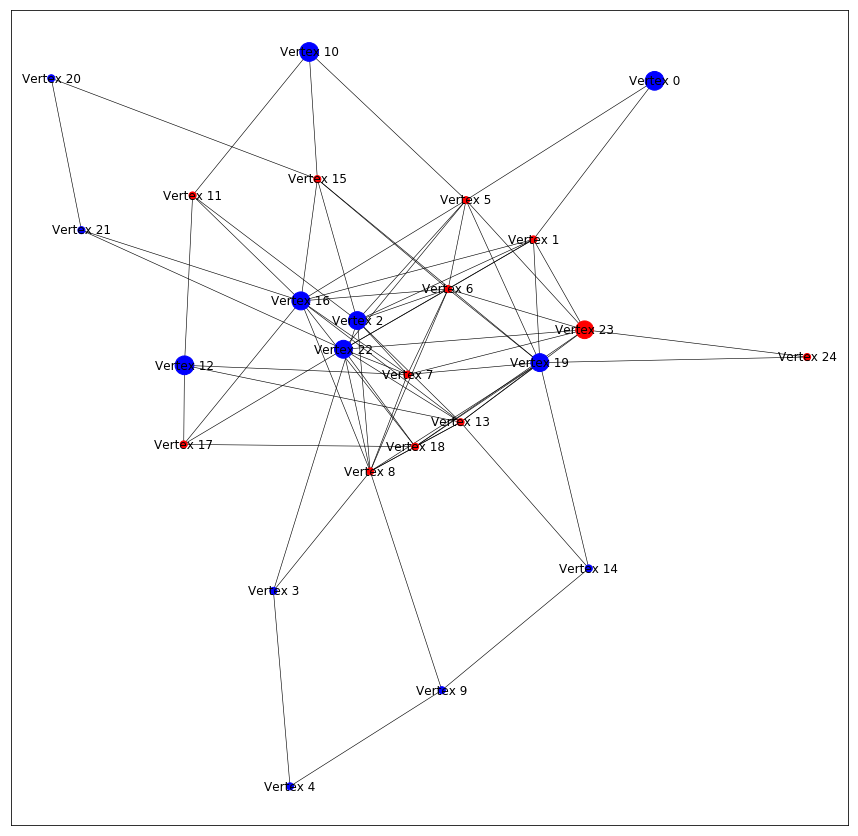

-----------------------------------------
Vertex 0 degree 2 budget 0.16666666666666663
[(-1.0, 0.24, -0.09722222222222221), (0.0, 0.12, -0.09722222222222221), (-1.0, 0.07999999999999996, -0.09027777777777773), (-1.0, 0.31999999999999995, -0.09722222222222221), (-1.0, 0.28, -0.09722222222222221), (-1.0, 0.24, -0.09722222222222221), (0.0, 0.16000000000000003, -0.09722222222222221)]
[0.14277777777777778, 0.022777777777777786, -0.010277777777777775, 0.22277777777777774, 0.18277777777777782, 0.14277777777777778, 0.06277777777777782]
[Vertex 2, Vertex 6, Vertex 10, Vertex 16, Vertex 19, Vertex 22, Vertex 23]
chose 1 (0.0, 0.12, -0.09722222222222221) 0.0
chosen vtx Vertex 6
chose do nothing
###########################
Vertex 1 degree 7 budget 0.6249999999999999
[(0.0, 0.022222222222222227, -0.09027777777777768), (0.0, 0.15555555555555553, -0.1319444444444443), (0.0, 0.13333333333333333, -0.12499999999999989), (0.0, 0.1111111111111111, -0.11805555555555547), (0.0, 0.04444444444444445, -0.09722

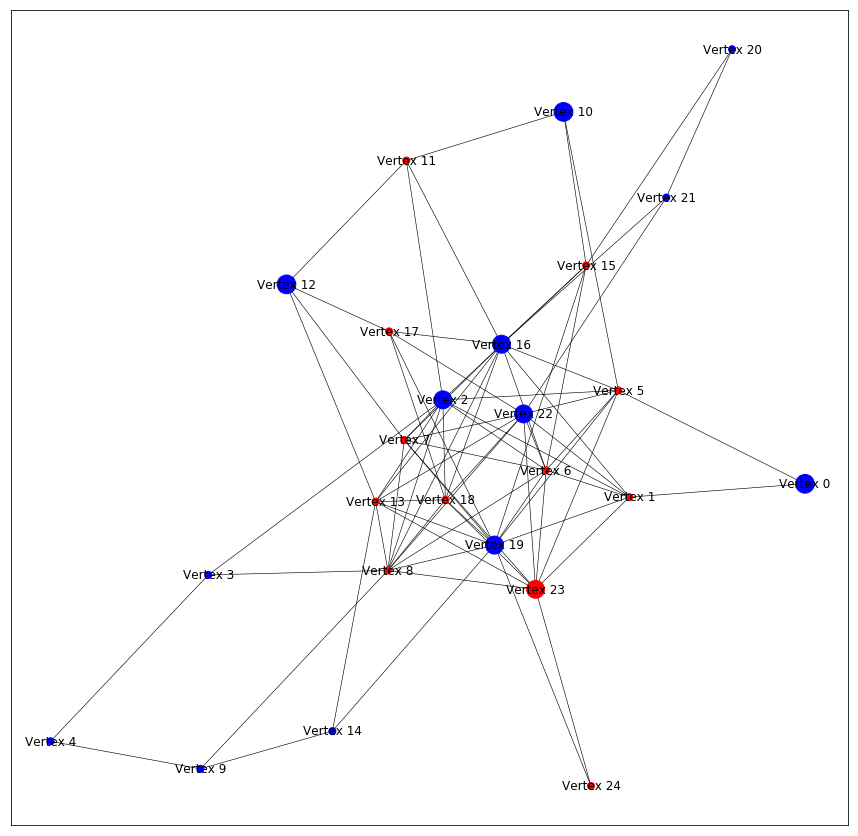

-----------------------------------------
Vertex 0 degree 2 budget 0.16666666666666663
[(-1.0, 0.28, -0.09722222222222221), (-1.0, 0.07999999999999996, -0.09027777777777773), (-1.0, 0.31999999999999995, -0.09722222222222221), (-1.0, 0.31999999999999995, -0.09722222222222221), (-1.0, 0.24, -0.09722222222222221), (0.0, 0.19999999999999996, -0.09722222222222221)]
[0.18277777777777782, -0.010277777777777775, 0.22277777777777774, 0.22277777777777774, 0.14277777777777778, 0.10277777777777775]
[Vertex 2, Vertex 10, Vertex 16, Vertex 19, Vertex 22, Vertex 23]
chose 5 (0.0, 0.19999999999999996, -0.09722222222222221) 0.0
chosen vtx Vertex 23
chose do nothing
###########################
Vertex 1 degree 7 budget 0.6249999999999999
[(0.0, 0.022222222222222227, -0.09027777777777768), (0.0, 0.15555555555555553, -0.1319444444444443), (0.0, 0.13333333333333333, -0.12499999999999989), (0.0, 0.04444444444444445, -0.09722222222222221), (0.0, 0.1111111111111111, -0.11805555555555547), (0.0, 0.0222222222222

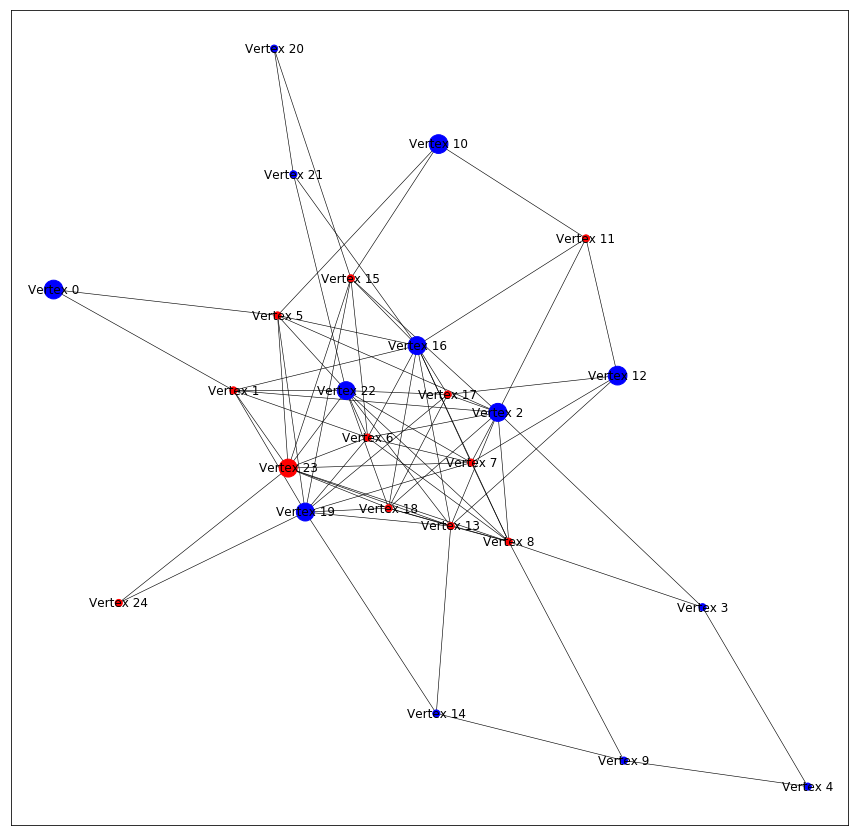

-----------------------------------------
Vertex 0 degree 2 budget 0.16666666666666663
[(-1.0, 0.31999999999999995, -0.09722222222222221), (0.0, 0.12, -0.09027777777777773), (-1.0, 0.07999999999999996, -0.09027777777777773), (-1.0, 0.31999999999999995, -0.09722222222222221), (-1.0, 0.28, -0.09722222222222221), (-1.0, 0.24, -0.09722222222222221), (0.0, 0.24, -0.09722222222222221)]
[0.22277777777777774, 0.02972222222222226, -0.010277777777777775, 0.22277777777777774, 0.18277777777777782, 0.14277777777777778, 0.14277777777777778]
[Vertex 2, Vertex 6, Vertex 10, Vertex 16, Vertex 19, Vertex 22, Vertex 23]
chose 1 (0.0, 0.12, -0.09027777777777773) 0.0
chosen vtx Vertex 6
chose do nothing
###########################
Vertex 1 degree 7 budget 0.6249999999999999
[(0.0, 0.022222222222222227, -0.09027777777777768), (0.0, 0.13333333333333333, -0.12499999999999989), (0.0, 0.13333333333333333, -0.12499999999999989), (0.0, 0.1111111111111111, -0.11805555555555547), (0.0, 0.04444444444444445, -0.09722

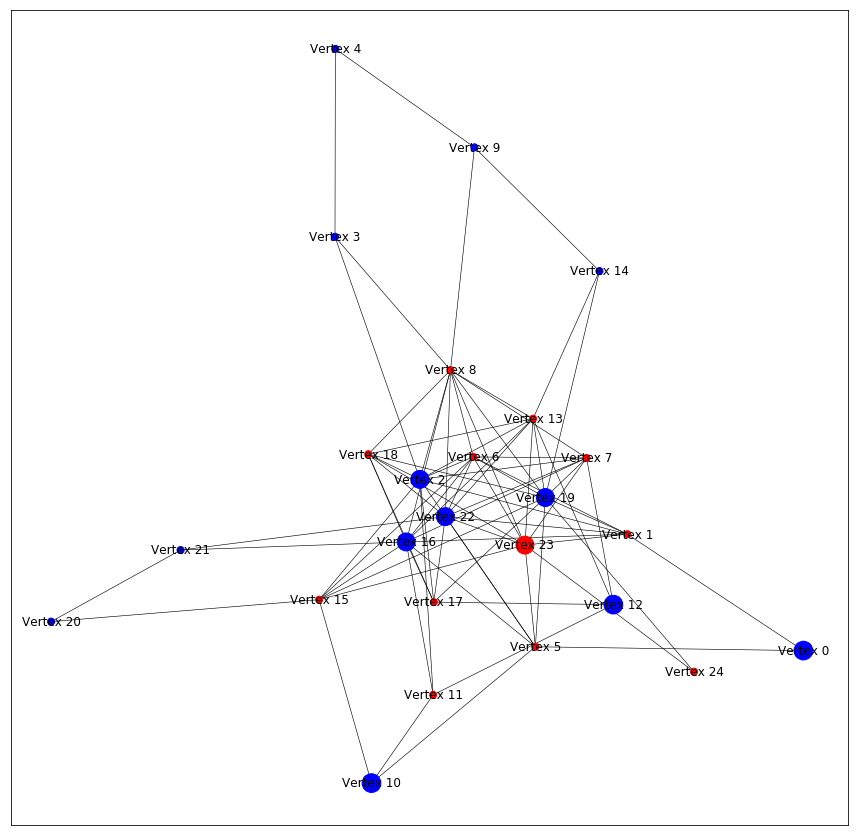

Final unique attribute counts (summed)
[(0.006402617718452408, 24), (0.040281173730108755, 24), (0.058476296457308785, 24), (0.1464094861511701, 24), (0.2125981784698291, 24), (0.2540976567161217, 24), (0.34924946249655486, 24), (0.37680332428971197, 24), (0.4331173326652117, 24), (0.447327340946454, 24), (0.5430909028384362, 24), (0.5475892383493655, 24), (0.5512814745647842, 24), (0.5650493437231211, 24), (0.5756057304920785, 24), (0.5790617525590382, 24), (0.614258412910112, 24), (0.6505618488856744, 24), (0.7810129580024977, 24), (0.8033362358268185, 24), (0.8314627413307444, 24), (0.8318049537817541, 24), (0.9303318389698414, 24), (0.9750935031455141, 24), (0.9772329766923534, 24)]


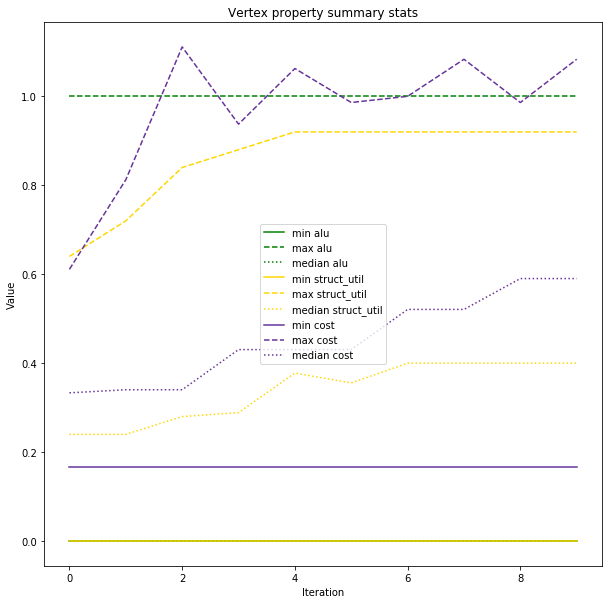

<Figure size 720x720 with 0 Axes>

In [5]:
G = attribute_network(_N, params)
print(G.sim_params)

summary_stat_vals = ['alu', 'struct_util', 'cost']
summary_funcs = [ min, max, np.median ]
summary_func_names = ['min', 'max', 'median']
summary_stats = { val : { name : [] for name in summary_func_names } \
                 for val in summary_stat_vals }
stat_val_colors = ['green', 'gold', 'rebeccapurple']
summary_func_styles = ['-', '--', ':']

print('Initial graph')
vis.draw_graph(G)
for it in range(num_iters):
    if it < add_to_iter:
        add_attr_graph_vtx(G)
        
    meets_log = (log_every != 0) and ((it % log_every == 0) or (it >= num_iters - log_last))
    if meets_log:
        G.sim_params['edge_selection'] = alu.seq_edge_sel_logged
    else:
        G.sim_params['edge_selection'] = alu.seq_edge_sel_silent
    
    calc_edges(G)
    seq_global_walk(G)
    for v in [ v for v in G.vertices if v.degree == 0 ]:
        alu.indep_context_proposal(G, v)
        
    # Sim iter end, start stat collection
    attr_util_vals = [ u.data['total_attr_util'](u, G) for u in G.vertices ]
    struct_util_vals = [ u.data['struct_util'](u, G) for u in G.vertices ]
    costs = [ alu.calc_cost(u, G) for u in G.vertices ]
    values = [attr_util_vals, struct_util_vals, costs]
    
    for si in range(len(summary_stat_vals)):
        for fi in range(len(summary_funcs)):
            ss_val = summary_funcs[fi](values[si])
            summary_stats[summary_stat_vals[si]][summary_func_names[fi]].append(ss_val)
            
    if it % show_every == 0 or it >= num_iters - show_last:
        print('Iteration:', it)
        print_metrics(G)
        vis.draw_graph(G)

plt.figure(figsize=(10,10))
x_vals = list(range(num_iters))
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.title("Vertex property summary stats")
for si in range(len(stat_val_colors)):
    for fi in range(len(summary_func_styles)):
        plt.plot(x_vals,
                 summary_stats[summary_stat_vals[si]][summary_func_names[fi]],
                 color=stat_val_colors[si],
                 linestyle=summary_func_styles[fi],
                 label='{0} {1}'.format(summary_func_names[fi], summary_stat_vals[si]))
plt.legend()

plt.figure(figsize=(10,10))
def get_counts(v):
    counts = {}
    for ctxt in v.attr_obs.keys():
        counts[ctxt] = {}
        for attr, obs in v.attr_obs[ctxt].items():
            counts[ctxt][attr] = len(obs)
    return counts

attr_counts = [ get_counts(v) for v in G.vertices ]
final_attr_counts = defaultdict(lambda : 0)
for count_set in attr_counts:
    for attr_obs_counts in count_set.values():
        for attr, attr_cnt in attr_obs_counts.items():
            final_attr_counts[attr] += attr_cnt
print("Final unique attribute counts (summed)")
attr_list = list(final_attr_counts.keys())
attr_list.sort()
attr_count_list = [ final_attr_counts[atr] for atr in attr_list ]
print(list(zip(attr_list, attr_count_list)))

plt.show()